In [4]:
import os
import numpy as np 
import glob
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from utils import project_pca, calculate_Q_metrics

from warnings import simplefilter
simplefilter('ignore')

%matplotlib inline

# Load and preprocess data

In [5]:
# !wget https://figshare.com/ndownloader/files/33927092 -O data.zip

In [6]:
data_orig = {}

for dataset_name in tqdm(['AGP', 'HMP']):
    for tax in ['o', 'f', 'g']: 
        dataframe = pd.read_csv(f'./data/{dataset_name}/pivot_{tax}_normalized.csv', sep=';')
        label = f'{dataset_name}_{tax}'
        data_orig[label] = dataframe.drop('Unnamed: 0', axis=1)

processed_root = 'data_processed'
pca_root = './results/pca/' 
os.makedirs('data_processed', exist_ok=True)
os.makedirs(pca_root, exist_ok=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.28it/s]


In [7]:
# # uncomment to use synthetic data

# data_orig = {}
# for path in glob.glob('data/synthetic/*'):
#     dataframe = pd.read_csv(path, index_col=0)
#     label = path.split('/')[-1]
#     data_orig[label] = dataframe.drop('target', axis=1)

# processed_root = 'data_processed/synthetic'
# pca_root = './results/pca/synthetic'
# os.makedirs(processed_root, exist_ok=True)
# os.makedirs(pca_root, exist_ok=True)

# Preprocessing

In [8]:
# requirement that OTU shound be present at least in RARITY_THRESHOLD percentage of population
RARITY_THRESHOLD = 0.01 
# requirement that OTU variance among population 
STD_THRESHOLD = 1e-3

preprocessed_data = {}

for label, df in data_orig.items():
            
    df_proc = df.copy()
    df_proc.drop_duplicates(inplace=True)
    N = df_proc.shape[0]
    
    # too rare
    rare_otu_mask = (df_proc > 0).sum(0) / N < RARITY_THRESHOLD
    
    # too low std
    std_otu_mask = df_proc.std(0) < STD_THRESHOLD
    
    mask = rare_otu_mask + std_otu_mask
    df_proc = df_proc.iloc[:,~mask.values]
    preprocessed_data[label] = df_proc
    
#     path = os.path.join(processed_root, f'{label}.csv')
#     df_proc.to_csv(path)
    print(f'{label} Orig shape: {df.shape}, processed shape: {df_proc.shape}')
    

AGP_o Orig shape: (9511, 168), processed shape: (9511, 39)
AGP_f Orig shape: (9511, 258), processed shape: (9511, 69)
AGP_g Orig shape: (9511, 535), processed shape: (9511, 108)
HMP_o Orig shape: (4587, 179), processed shape: (4558, 39)
HMP_f Orig shape: (4587, 267), processed shape: (4564, 70)
HMP_g Orig shape: (4587, 574), processed shape: (4563, 97)


In [12]:
data_projected, pca, pca_proj, mae = project_pca(df_proc, whiten=False)

<BarContainer object of 40 artists>

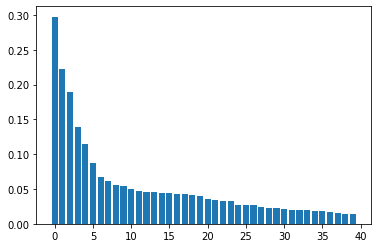

In [16]:
plt.bar(np.arange(data_projected.shape[1]), data_projected.std(0))

<AxesSubplot:>

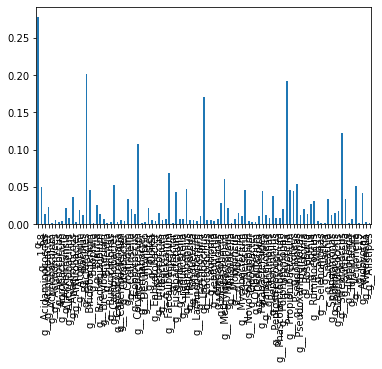

In [10]:
df_proc.std(0).plot.bar()

# PCA

For AGP_o, dim orig: 39, dim PCA: 16, mae: 0.061, Q_loc: 0.904, Q_glob: 0.993
For AGP_f, dim orig: 69, dim PCA: 34, mae: 0.041, Q_loc: 0.96, Q_glob: 0.995
For AGP_g, dim orig: 108, dim PCA: 47, mae: 0.05, Q_loc: 0.951, Q_glob: 0.993
For HMP_o, dim orig: 39, dim PCA: 18, mae: 0.036, Q_loc: 0.911, Q_glob: 0.99
For HMP_f, dim orig: 70, dim PCA: 35, mae: 0.044, Q_loc: 0.919, Q_glob: 0.987
For HMP_g, dim orig: 97, dim PCA: 40, mae: 0.058, Q_loc: 0.921, Q_glob: 0.99


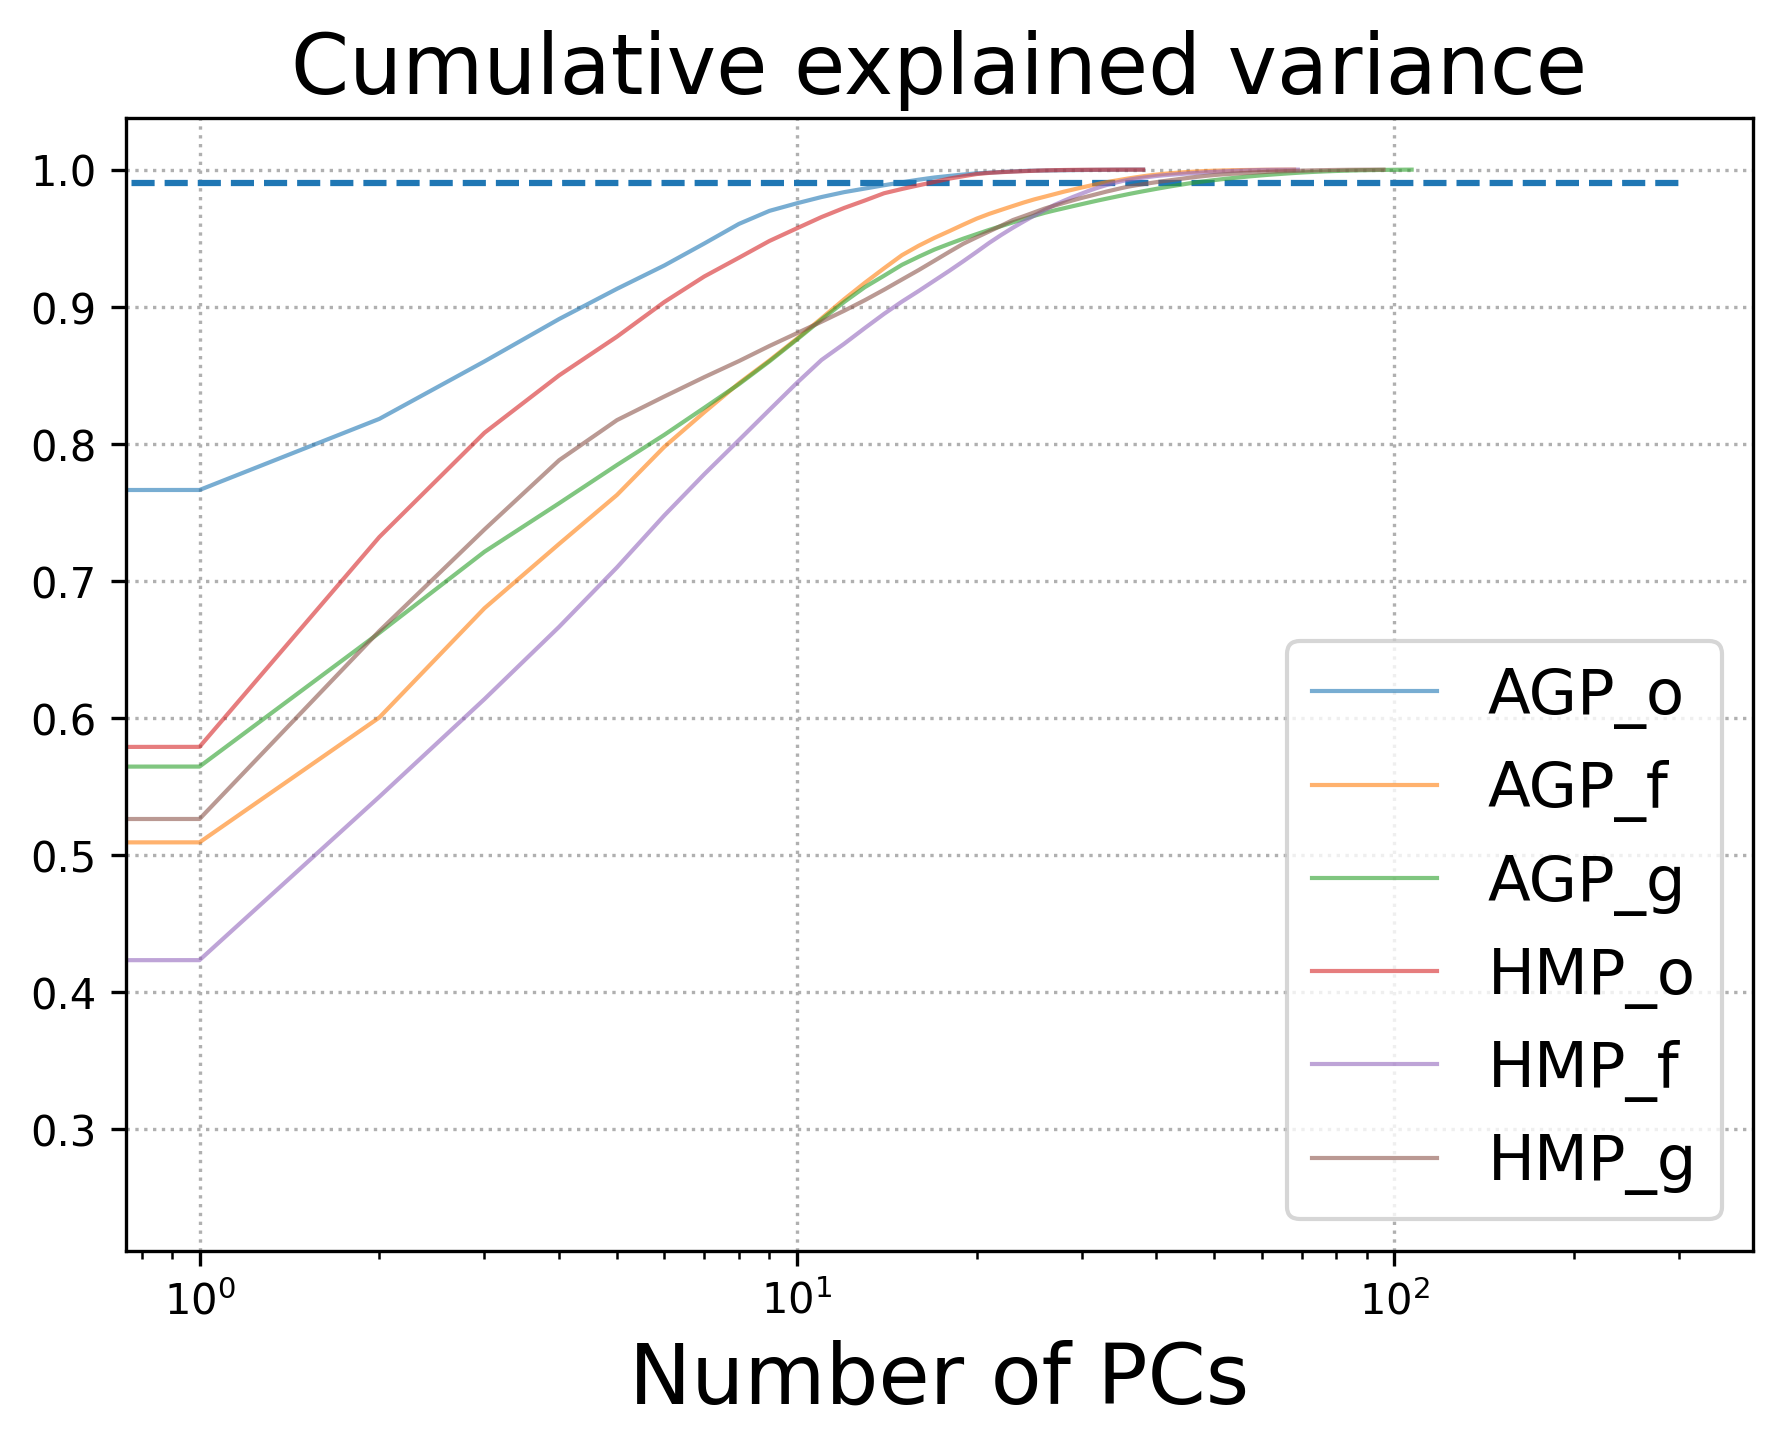

In [17]:
SAVE=True

plt.figure(figsize=(7,5), dpi=300)
plt.title(f"Cumulative explained variance", fontsize=20)
plt.xlabel("Number of PCs", fontsize=20)
plt.hlines(0.99,0,300,linestyle='--')

plt.grid(linestyle="dotted")

for label, df in preprocessed_data.items():
    
    data_projected, pca, pca_proj, mae = project_pca(df, whiten=False)
       
    d_pca = data_projected.shape[1]
    d = df.shape[1]
    
    plt.plot(np.cumsum(pca.explained_variance_ratio_), 
            linewidth=1, 
            label=label,
            alpha=0.6)  
    
    Q_loc, Q_glob = calculate_Q_metrics(df.values, data_projected)
    
    print(f'For {label}, dim orig: {d}, dim PCA: {d_pca}, mae: {np.round(mae,3)}, Q_loc: {np.round(Q_loc,3)}, Q_glob: {np.round(Q_glob,3)}')
    
    if SAVE:
        path = os.path.join(pca_root, f'{label}')
        np.savetxt(path, data_projected, delimiter = ';')

plt.xscale('log')
plt.legend(fontsize=15)       
plt.show()    

# Calculate pairwise distances*
*for the faster computation

In [44]:
from scipy.spatial.distance import braycurtis, pdist, squareform, jensenshannon
from joblib import Parallel, delayed


distance_root = 'distances_processed'
os.makedirs(distance_root, exist_ok=True)
distances_names = ['L1', 'L2', 'JS', 'BC']

# distance_root = 'distances_processed_synth'
# os.makedirs(distance_root, exist_ok=True)
# # only L1 and L2 distances are supported
# distances_names = ['L1', 'L2']

In [30]:
def compute_pdist_l1(data, name, distance_root):
    data_ = data.copy()
    S = squareform(pdist(data_, metric='minkowski', p=1))
    path = os.path.join(distance_root, f'orig_L1_{name}')
    np.save(path, S)
    
_ = Parallel(n_jobs=len(preprocessed_data))(delayed(compute_pdist_l1)(data.values, name, distance_root) 
                                        for name, data in preprocessed_data.items())

In [52]:
def compute_pdist_l2(data, name, distance_root):
    data_ = data.copy()
    S = squareform(pdist(data_, metric='minkowski', p=2))
    path = os.path.join(distance_root, f'orig_L2_{name}')
    np.save(path, S)
    
_ = Parallel(n_jobs=len(preprocessed_data))(delayed(compute_pdist_l2)(data.values, name, distance_root) 
                                        for name, data in preprocessed_data.items())

In [51]:
def compute_pdist_js(data, name, distance_root):
    
    data_ = data.copy()
    data_ /= data_.sum(1, keepdims=True)
    
    N = data_.shape[0]
    S = np.zeros((N,N))
    for i in range(N):
        for j in range(i+1,N):
            d = jensenshannon(data_[i], data_[j])
            S[i,j] = d
            S[j,i] = d
            
    path = os.path.join(distance_root, f'orig_JS_{name}')
    np.save(path, S)
    
if 'JS' in distances_names:
    _ = Parallel(n_jobs=len(preprocessed_data))(delayed(compute_pdist_js)(data.values, name, distance_root) 
                                            for name, data in preprocessed_data.items())

In [55]:
def compute_pdist_bc(data, name, distance_root):
    data_ = data.copy()
    N = data_.shape[0]
    data_ /= data_.sum(1, keepdims=True)
    
    S = np.zeros((N,N))2
    for i in range(N):
        for j in range(i+1,N):
            d = braycurtis(data_[i], data_[j])
            S[i,j] = d
            S[j,i] = d
            
    path = os.path.join(distance_root, f'orig_BC_{name}')
    np.save(path, S)
    
if 'BC' in distances_names:
    _ = Parallel(n_jobs=len(preprocessed_data))(delayed(compute_pdist_bc)(data.values, name, distance_root) 
                                            for name, data in preprocessed_data.items())